# CubiCasa / FloorplantoBlenderlib

In [ ]:
import os
import requests
import tarfile

def download_file_with_timeout_and_parts(url, output_path):
    session = requests.Session()
    session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
    session.mount('https://', requests.adapters.HTTPAdapter(max_retries=3))

    # Attempt to download in parts if supported
    part_size = 1024 * 1024 * 10  # 10 MB per part
    total_size = int(session.head(url).headers.get('content-length', 0))
    print(f"Total size: {total_size}")

    with open(output_path, 'wb') as f:
        for start in range(0, total_size, part_size):
            end = min(start + part_size - 1, total_size - 1)
            print(f"Downloading: {start}-{end}")
            headers = {'Range': f'bytes={start}-{end}'}
            response = session.get(url, headers=headers, stream=True, timeout=30)
            response.raise_for_status()
            for chunk in response.iter_content(8192):
                f.write(chunk)

# Download URL
blender_url = "https://ftp.nluug.nl/pub/graphics/blender/release/Blender2.93/blender-2.93.1-linux-x64.tar.xz"
blender_output = 'blender.tar.xz'
download_file_with_timeout_and_parts(blender_url, blender_output)

# Extracting Blender
blender_version = 'blender-2.93.1'
if not os.path.exists(blender_version):
    os.makedirs(blender_version)
with tarfile.open(blender_output, 'r:xz') as tar:
    tar.extractall(path=blender_version)
os.remove(blender_output)

Total size: 166685444
Downloading: 0-10485759
Downloading: 10485760-20971519
Downloading: 20971520-31457279
Downloading: 31457280-41943039
Downloading: 41943040-52428799
Downloading: 52428800-62914559
Downloading: 62914560-73400319
Downloading: 73400320-83886079
Downloading: 83886080-94371839
Downloading: 94371840-104857599
Downloading: 104857600-115343359
Downloading: 115343360-125829119
Downloading: 125829120-136314879
Downloading: 136314880-146800639
Downloading: 146800640-157286399
Downloading: 157286400-166685443


C:\Users\muham\AppData\Local\Temp\ipykernel_13668\3048624260.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=blender_version)


In [ ]:
# Add outer folder
 # Adds higher directory to python modules path.

# Install pyfiglet
%pip install pyfiglet

# Import library
from utils.FloorplanToBlenderLib import *

# Other necessary libraries
import numpy as np


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Input image: ![input](Images/example.png)

# Detect Contours (Object Filter)

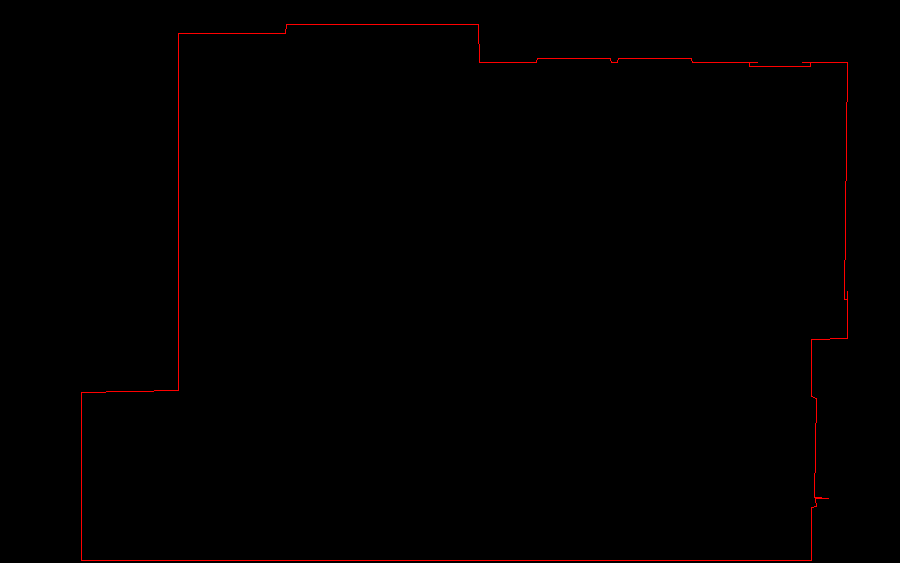

In [1]:

# Import library
from utils.FloorplanToBlenderLib import *

import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

img_path = r"C:\Users\haier\Documents\clone Electrical\Floor-Plan-Detection-main\Images\example.png"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img = detect.detectOuterContours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(img))

# Detect Rooms (Object Filter)

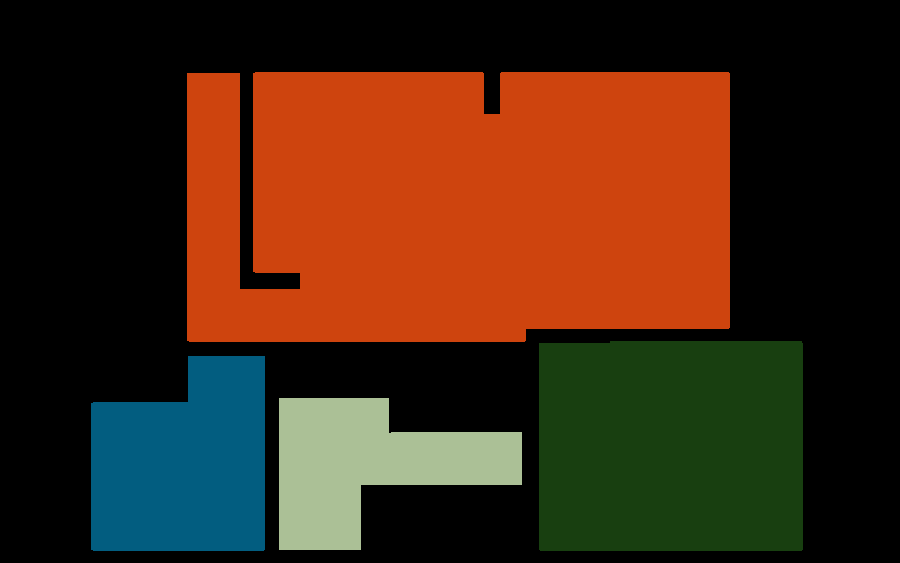

In [2]:
img = cv2.imread(img_path)

    # grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
height = 0.999

# Scale pixel value to 3d pos
scale = 100

gray = detect.wall_filter(gray)

gray = ~gray

rooms, colored_rooms = detect.find_rooms(gray.copy())

gray_rooms =  cv2.cvtColor(colored_rooms,cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
display(Image.fromarray(colored_rooms))

 #Create verts
room_count = 0
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, height)])
    room_count+= 1

# create faces
for room in verts:
    count = 0
    temp = ()
    for pos in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# Detect Walls (Object Filter)

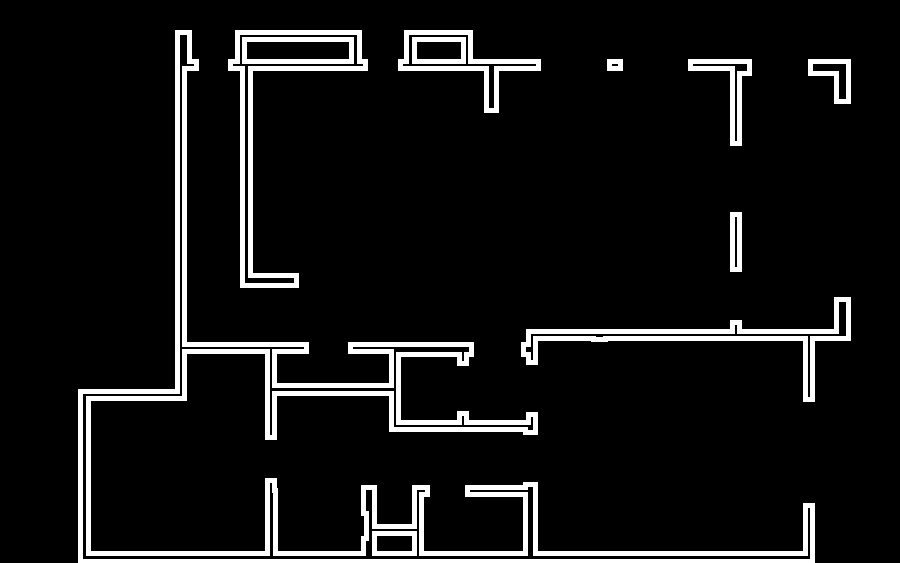

In [6]:
'''
    Generate wall data file for floorplan
    @Param img_path, path to input file
    @Param info, boolean if data should be printed
    @Return shape
    '''
from utils.FloorplanToBlenderLib import *
# Read floorplan image
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)

# detect walls
boxes, img = detect.detectPreciseBoxes(wall_img)

display(Image.fromarray(wall_img))

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
wall_height = 1

# Scale pixel value to 3d pos
scale = 100

# Convert boxes to verts and faces
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# CubiCasa Pre-Trained Object/Room Segmentation          
# (Deep Neural Network)

In [ ]:
import sys
import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Add your repository folder to the Python modules path
sys.path.append(r"C:\Users\haier\Documents\clone Electrical\Floor-Plan-Detection-main")

# Import library
from utils.FloorplanToBlenderLib import *
from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

# Define room and icon classes
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room", "Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Appliance", "Toilet", "Sink",
                "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

# Initialize model
model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)

# Check if CUDA is available and load the model accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = r"C:\Users\haier\Documents\clone Electrical\Floor-Plan-Detection-main\model\model_1427.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Inspect the keys in the checkpoint
print("Checkpoint keys:", checkpoint.keys())

# Load the model state
try:
    if 'model_state' in checkpoint:
        model.load_state_dict(checkpoint['model_state'])
    elif 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)
except RuntimeError as e:
    print("Error in loading state_dict: ", e)
    print("Attempting to load with strict=False...")
    if 'model_state' in checkpoint:
        model.load_state_dict(checkpoint['model_state'], strict=False)
    elif 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    else:
        model.load_state_dict(checkpoint, strict=False)

model.eval()
model.to(device)

# Preprocess and load image
img_path = r"C:\Users\haier\Documents\clone Electrical\Floor-Plan-Detection-main\Images\example.png"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Correct color channels

# Downscale image for faster processing
desired_width = 512
h, w, _ = img.shape
new_height = int(h * desired_width / w)
img = cv2.resize(img, (desired_width, new_height), interpolation=cv2.INTER_AREA)

# Image transformation to range (-1,1)
img = 2 * (img / 255.0) - 1

# Move from (h,w,3) -> (3,h,w) as model input dimension is defined like this
img = np.moveaxis(img, -1, 0)

# Convert to PyTorch tensor and enable CUDA if available
img = torch.tensor([img.astype(np.float32)]).to(device)

# Initialize variables
n_rooms = 12
n_icons = 11
rot = RotateNTurns()

with torch.no_grad():
    # Check if shape of image is odd or even
    size_check = np.array([img.shape[2], img.shape[3]]) % 2

    if size_check[0] > 0 or size_check[1] > 0:
        height = img.shape[2] - size_check[0]
        width = img.shape[3] - size_check[1]
    else:
        height = img.shape[2]
        width = img.shape[3]

    img_size = (height, width)

    # Reduce the number of rotations to speed up predictions
    rotations = [(0, 0), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # Rotate the image
        rot_image = rot(img, 'tensor', forward)
        pred = model(rot_image)
        # Rotate prediction back
        pred = rot(pred, 'tensor', back)
        # Fix heatmaps
        pred = rot(pred, 'points', back)
        # Ensure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # Add the prediction to output
        prediction[i] = pred[0]

# Average the predictions
prediction = torch.mean(prediction, 0, True)

# Process predictions
rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers = [i for i, j in enumerate(types) if j['type'] == 'wall']
boxes = []
for i, j in enumerate(polygons):
    if i in wall_polygon_numbers:
        temp = []
        for k in j:
            temp.append(np.array([k]))
        boxes.append(np.array(temp))

verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# Create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# Generate color-coded segmentation masks for rooms and icons
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types,
                                               height, width)

# Display the segmentation with graphical interface using Matplotlib
plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()



# can specify or use default paths in config files
stl.createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True)  
# Note: USE SR_Check = False for Original Image

In [ ]:
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

# Generate data files and Blender files (Using CubiCasa and Super-Resolution)

In [ ]:

import FloorplanToSTL as stl
import config

# can specify or use default paths in config files
stl.createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True)

# Note: USE SR_Check = False for Original Image